# The SEG-EAGE 3D salt model

This notebook compute one shot from the [3D SEG-EAGE salt model](https://wiki.seg.org/wiki/SEG/EAGE_Salt_and_Overthrust_Models), which is extensively used to test 3D migration algorithms. It is publicly avaiable. Let's first download it.

In [1]:
import os
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from SeisCL import SeisCL
from IPython.core.pylabtools import figsize

url = 'http://s3.amazonaws.com/open.source.geoscience/open_data/seg_eage_salt/SEG_C3NA_Velocity.sgy'

#From segy headers
NZ = 201
NY = 676
NX = 676
dh = 20

models = {'vp': None}

if not os.path.isfile('SEG_C3NA_Velocity.sgy'):
    urlretrieve(url, 'SEG_C3NA_Velocity.sgy')

vp =SeisCL.read_segy(None, 'SEG_C3NA_Velocity.sgy')
vp = np.reshape(vp, [NZ, NY, NX])[:(NZ-NZ%2), :(NY-NY%2), :(NX-NX%2)]

For inversion, we often want a coaser grid. We must also pad the model for the absorbing boundary and create the vs and rho paramters.

In [2]:
seis = SeisCL()
vp = np.pad(vp, ((seis.nab, seis.nab), (seis.nab, seis.nab), (seis.nab, seis.nab)), mode="edge")
rho = vp * 0 + 2000
vs = vp * 0

model = {'vp':vp, 'vs':vs, 'rho':rho}
NZ, NY, NX = vp.shape

Let's first show the velocity model.

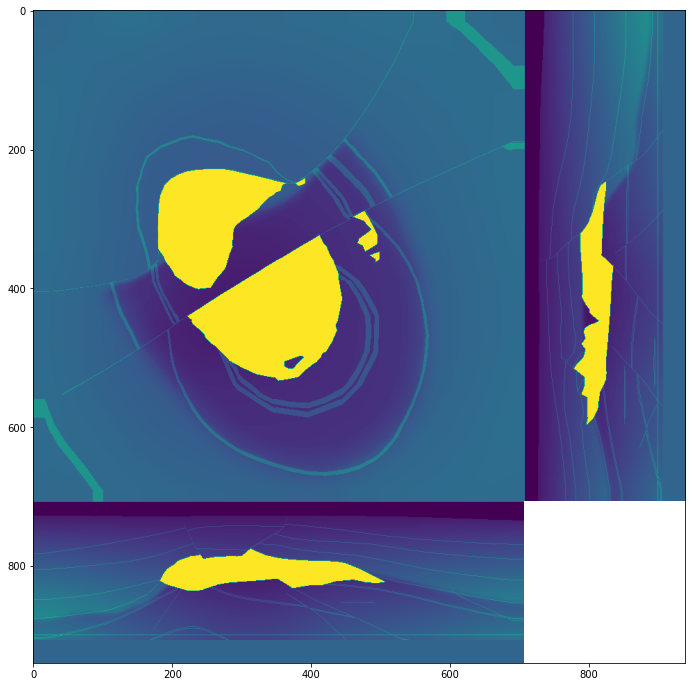

In [3]:
figsize(12, 12)
fig, ax = plt.subplots()
toplot = np.zeros([NZ+NY, NZ+NX]) + np.NaN
toplot[:NY, :NX] = vp[NZ//2, :, :]
toplot[NY:, :NX] = vp[:, NY//2, :]
toplot[:NY, NX:] = np.transpose(vp[:, :, NX//2])
plt.imshow(toplot)
plt.show()

We create an instance of `SeisCL` and setup the geometry.

In [6]:
seis.N = vp.shape
seis.ND = 3
seis.dh = dh
seis.dt = dt = 6 * seis.dh / (7 * np.sqrt(2) * np.max(vp)) * 0.7
seis.NT = int(3 / seis.dt)

In [7]:
sx = seis.N[2] // 2 * dh
sy = seis.N[1] // 2 * dh
sz = (seis.nab + 5) * dh
srcid = 0
src_type = 100

seis.src_pos_all = np.stack([[sx], [sy], [sz], [srcid], [src_type]], axis=0)

In [12]:
gx = np.arange(seis.nab + 5, seis.N[2] - seis.nab - 5, 1) * dh
gy = gx * 0 + seis.N[1] // 2 * dh
gz = gx * 0 + (seis.nab + 5) * dh
gsid = gx*0
recid = np.arange(0, len(gx)) + 1
blank = gx*0

seis.rec_pos_all = np.stack([gx, gy, gz, gsid, recid, blank, blank, blank], axis=0)

We can now compute the seismogram (this may take a while and requires more than 9GB of GPU memory).

In [ ]:

seis.set_forward([0], model, withgrad=False)
seis.execute()
data = seis.read_data()

The figure showing the recorded data is finally created.

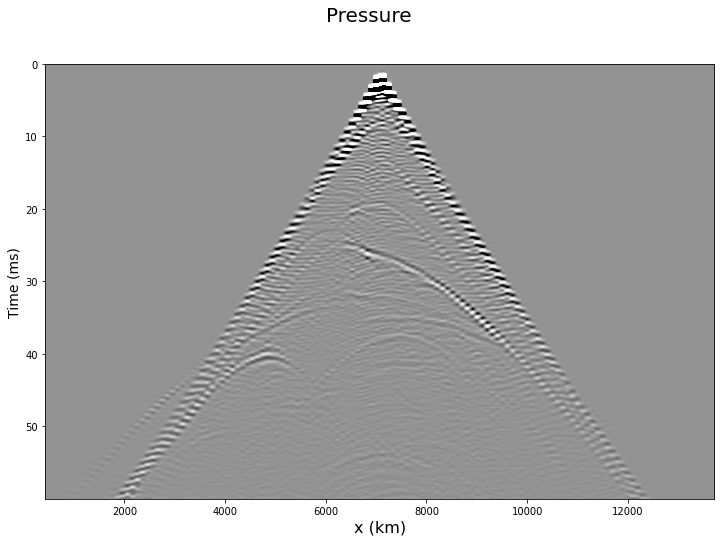

In [11]:
figsize(12, 8)
p = data[0]
xmin = np.min(seis.rec_pos_all[0, :])
xmax = np.max(seis.rec_pos_all[0, :])
clip=0.01;
vmin=np.min(p)*clip;
vmax=np.max(p)*clip;
fig, ax = plt.subplots()
im = ax.imshow(p, 
               interpolation='bilinear', 
               vmin=vmin, 
               vmax=vmax, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper',
               extent=[xmin,xmax, p.shape[0]*seis.dt*20,0]
               )
fig.suptitle('Pressure', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.show()